## Asset Matching using Python

## Introduction

The two sets of data on the other sheets represent two datasets of same assets along a length of carriageway. Each instance in each set has a unique identifier (UID) and coordinates. 

However the data are from two different sources so what is supposed to be the same asset  are positioned in slightly different places in each dataset, and carry a different UID. The task is to find for each asset in set1 its corresponding asset in set2. which will be the nearest. The output is expected to be a list of Set1 UID alongside the corresponding UID for the point from Set2.


### 1.Import the required libraries

Below are the libraries that are used in this JupyterNotebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### binary search or big O notation??
import pandas, numpy and matplotlib
use matplotlib to plot the data
def a function for binary search?
match x-coordina then match y coordinate?
oen method might be to 

Use pandas read csv package to read the 2 csv into DataFrames###


### 2.Loading & clean data

Loading the data into the pandas dataframew and inspect the data.

In [2]:
asset_1 = pd.read_csv("set_1.csv")
asset_2 = pd.read_csv("set_2.csv")

print(asset_1.head(), '\n', asset_1.shape)
print(asset_2.head(), '\n', asset_2.shape)



   X_Easting_  Y_Northing  ID
0      332476      445069  A1
1      332496      444969  A2
2      332502      445003  A3
3      332514      444897  A4
4      332516      444935  A5 
 (38, 3)
           X          Y UID
0  332498.44  445039.62  Z1
1  332493.84  444971.72  Z2
2  332697.88  444223.53  Z3
3  332669.31  444328.00  Z4
4  332538.14  444811.84  Z5 
 (39, 3)


So we can clean the 2 sets of data first:
 - set the ID as index for each DataFrame
 - convert asset_1 coordinates to float for calculations


In [3]:
# asset_1.set_index('ID', inplace=True)
asset_1.rename(columns={'X_Easting_':'x', 'Y_Northing':'y',}, inplace=True)

# asset_2.set_index('UID', inplace=True)
asset_2.rename(columns={'X':'x', 'Y':'y',}, inplace=True)

print(asset_1.dtypes, '\n')
print(asset_2.dtypes)

x      int64
y      int64
ID    object
dtype: object 

x      float64
y      float64
UID     object
dtype: object


Sort each set of data. Additionally we can drop the duplicate data within set_1 data and check the shape attributes to see how many of them were dropped:

In [4]:
asset_1['x'] = asset_1['x'].astype(float)
asset_1['y'] = asset_1['y'].astype(float)
print(asset_1.dtypes, '\n')

asset_1.sort_values(by=['x', 'y'], inplace=True)
asset_2.sort_values(by=['x', 'y'], inplace=True)
print(asset_1.head())
print(asset_2.head(), '\n')

asset_1.drop_duplicates(subset=['x', 'y'], inplace=True)
print(asset_1.shape)
asset_1.reset_index(inplace=True, drop=True)
asset_2.reset_index(inplace=True, drop=True)
print(asset_2.head())

x     float64
y     float64
ID     object
dtype: object 

          x         y  ID
0  332476.0  445069.0  A1
1  332496.0  444969.0  A2
2  332502.0  445003.0  A3
3  332514.0  444897.0  A4
4  332516.0  444935.0  A5
            x          y  UID
25  332477.36  445068.32  Z26
1   332493.84  444971.72   Z2
0   332498.44  445039.62   Z1
16  332499.14  445000.25  Z17
22  332510.64  444896.40  Z23 

(36, 3)
           x          y  UID
0  332477.36  445068.32  Z26
1  332493.84  444971.72   Z2
2  332498.44  445039.62   Z1
3  332499.14  445000.25  Z17
4  332510.64  444896.40  Z23


### 3.EDA & Computing the distance

The distance calculation is simple pythagoras trigonometry, √(x² + y²) –  the coordinates within the data are national grid coordinates and they locate relatively close. This means we do not need to use **Haversine formula** which is for a correct calculation of the distance between points on the globe, which has a curved surface.


An outlier is a point or set of points that are different from other points. Sometimes they can be very high or very low. It's often a good idea to detect and remove the outliers. Because outliers are one of the primary reasons for resulting in a less accurate model. Hence it's a good idea to remove them. The outlier detection and removing that I am going to perform is called IQR score technique. Often outliers can be seen with visualizations using a box plot. Shown below are the box plot of MSRP, Cylinders, Horsepower and EngineSize. Herein all the plots, you can find some points are outside the box they are none other than outliers. The technique of finding and removing outlier that I am performing in this assignment is taken help of a tutorial from[ towards data science]

### Scatterplot

We can use scatter plots to look into the correlation between two sets of data. Here the scatter plots are plotted with x and y coordinates. With the plot given below, we can easily tell the relationship between the 2 sets of data

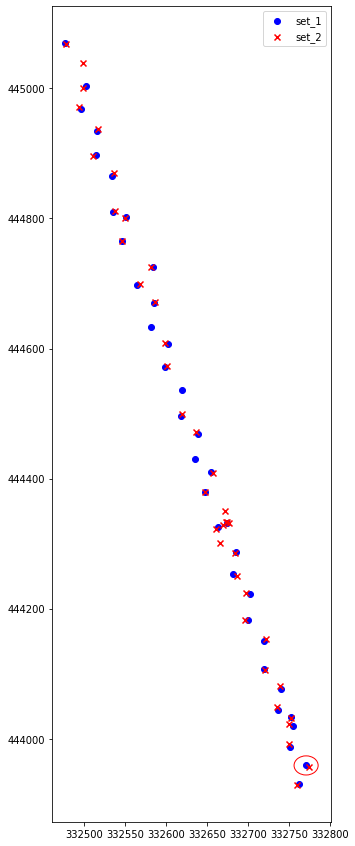

In [5]:
%matplotlib inline

circle1 = plt.Circle((332771.0, 443959.0), 14.705, fill=False, color='r')

fig = plt.figure(figsize=(5, 15)) # create a matplotlib figure
ax1 = fig.add_subplot(111) # create the same subplot for both sets of the data

ax1.scatter(asset_1['x'], asset_1['y'], c='b', marker="o", label='set_1')
ax1.scatter(asset_2['x'], asset_2['y'], c='r', marker="x", label='set_2')
ax1.add_patch(circle1)
plt.legend(loc='upper right')
plt.show()

From the graph above we can see that each blue point from set 1 has corresponding point from set 2 nearby. However there are also some outliners:
 - set 1 point at Easting 332675 (apoint ID A23) has a few points from set 2 around it. Hence only one point with the nearest distance should be matched to this point;
 - set 1 point at Easting 332750 (ID A34) has 2 similar assets from set 2. This suggests a nearest point from set 2 should be matched, and also the next point A35 will not match with any point

Base on the above observation, there shall be a maximum tolerence of distance difference to match a point from set 2 to set 1. The definition of this tolerence is key as it determines if a point in set 1 has a matching point within data set 2. This tolerence should roughly be half of the distance between a asset point and the asset point after.

We can first define a function to find the Euclidean distance between 2 points - we use Numpy's linalg.nor which returns one of an infinite number of vector norms, depending on the value of the ord parameter.


In [6]:

# build function to find Euclidean distance between two points
def distance(point_1, point_2):
    point_1 = np.array((point_1))
    point_2 = np.array((point_2))
    return np.linalg.norm(point_1 - point_2)

We start with adding an "error" column in set_1 DataFrame. Below we iterate through each point and find the nearest neighbour within set_1 - and then 1/2 of this nearest neighbour distance is saved to the error column.

In [7]:
error = []
for i, point in asset_1.iterrows():
    distances = []
    for j, compare in asset_1.iterrows():
        if j != i:
            dist = distance(point[['x','y']], compare[['x','y']])
            distances.append(dist)
        else:
            continue
    minimum = min(distances)
    print(minimum)
    error.append(minimum/2)

asset_1['error'] = error
asset_1.head()

70.9365914038728
34.52535300326414
34.52535300326414
36.89173349139343
38.05259518088089
36.89173349139343
17.88854381999832
36.345563690772494
17.88854381999832
33.60059523282288
32.802438933713454
34.66987164671943
33.60059523282288
36.124783736376884
32.802438933713454
35.0
40.049968789001575
28.284271247461902
35.0
31.78049716414141
28.284271247461902
12.083045973594572
12.083045973594572
34.132096331752024
34.132096331752024
37.73592452822641
36.05551275463989
36.89173349139343
37.73592452822641
18.601075237738275
32.14031735997639
31.25699921617557
15.297058540778355
15.297058540778355
29.410882339705484
29.410882339705484


,x,y,ID,error
0,332476.0,445069.0,A1,35.468296
1,332496.0,444969.0,A2,17.262677
2,332502.0,445003.0,A3,17.262677
3,332514.0,444897.0,A4,18.445867
4,332516.0,444935.0,A5,19.026298


After calculating the error/tolerence, we can start finding the closest point in set_2 to set_1. The method is similar to finding the nearest neighbour in set_1 here, however, if the nearest distance is greater than that point's error, we will say there is no matching point from set_2.

In [8]:
UID = []
for i in range(len(asset_1)):
    lengths = []
    tolerence = asset_1.iloc[i]['error']

    for j, set_2 in asset_2.iterrows():
        dist = distance(asset_1.iloc[i][['x','y']], set_2[['x','y']])
        if dist < tolerence:
            lengths.append((j,dist))

    if not lengths: # if no point from set_1 is found above we add NA
        UID.append(np.nan)
    else:
        minimum_pair = min(lengths, key = lambda tuple: tuple[1])
        print(minimum_pair)
        UID.append(asset_2.iloc[minimum_pair[0]]['UID'])
        


(0, 1.5205262246842384)
(1, 3.4733269353369787)
(3, 3.9676315353016456)
(4, 3.413151036780849)
(5, 2.4472433471072885)
(6, 4.796081734102163)
(7, 3.639395554234519)
(8, 0.7334848328109304)
(9, 1.5910059710761908)
(10, 3.968904130849142)
(11, 2.9753151093363486)
(12, 2.707397274171006)
(14, 3.4449383158368776)
(13, 4.016092628417523)
(15, 3.8087924595506903)
(16, 5.092317743421203)
(17, 0.8469356528416682)
(18, 3.239891973513515)
(19, 5.177847042917437)
(25, 1.2701574705712897)
(27, 4.579836241609416)
(26, 2.144411341154966)
(28, 3.905124837947365)
(29, 4.15394992747761)
(30, 2.111421322261398)
(31, 2.9960807732722032)
(32, 4.363141070402365)
(33, 4.136242255964361)
(34, 4.200190471899001)
(36, 1.94733150744666)
(35, 5.5102087074770205)
(37, 2.397352706601482)
(38, 4.030198506293647)


Below is the list of set_2 UID matching points in set_1 in order.

In [9]:
print(UID)

['Z26', 'Z2', 'Z17', 'Z23', 'Z6', 'Z13', 'Z5', 'Z14', 'Z11', 'Z35', nan, 'Z7', 'Z8', 'Z31', 'Z21', 'Z19', nan, nan, 'Z29', 'Z15', 'Z36', 'Z12', 'Z10', 'Z28', 'Z22', 'Z33', 'Z3', 'Z34', 'Z24', 'Z39', 'Z9', 'Z32', 'Z37', 'Z18', 'Z25', 'Z30']


This list is then broadcasted to the UID column of set_1 DataFrame.

In [10]:
asset_1['UID']=UID
print(asset_1.head())
print(asset_2.head())

          x         y  ID      error  UID
0  332476.0  445069.0  A1  35.468296  Z26
1  332496.0  444969.0  A2  17.262677   Z2
2  332502.0  445003.0  A3  17.262677  Z17
3  332514.0  444897.0  A4  18.445867  Z23
4  332516.0  444935.0  A5  19.026298   Z6
           x          y  UID
0  332477.36  445068.32  Z26
1  332493.84  444971.72   Z2
2  332498.44  445039.62   Z1
3  332499.14  445000.25  Z17
4  332510.64  444896.40  Z23


To plot and inspect the points again we can first merge these 2 data sets by referencing UID so both sets of coordinates are on the same DataFrame.

In [11]:
asset_update = asset_1.merge(asset_2, how='left', on='UID', suffixes=('_1', '_2'))
asset_update

,x_1,y_1,ID,error,UID,x_2,y_2
0,332476.0,445069.0,A1,35.468296,Z26,332477.36,445068.32
1,332496.0,444969.0,A2,17.262677,Z2,332493.84,444971.72
2,332502.0,445003.0,A3,17.262677,Z17,332499.14,445000.25
3,332514.0,444897.0,A4,18.445867,Z23,332510.64,444896.40
4,332516.0,444935.0,A5,19.026298,Z6,332516.61,444937.37
5,332534.0,444866.0,A6,18.445867,Z13,332536.90,444869.82
6,332535.0,444810.0,A7,8.944272,Z5,332538.14,444811.84
7,332546.0,444766.0,A8,18.172782,Z14,332546.72,444765.86
8,332551.0,444802.0,A9,8.944272,Z11,332549.87,444800.88
9,332565.0,444697.0,A10,16.800298,Z35,332567.99,444699.61


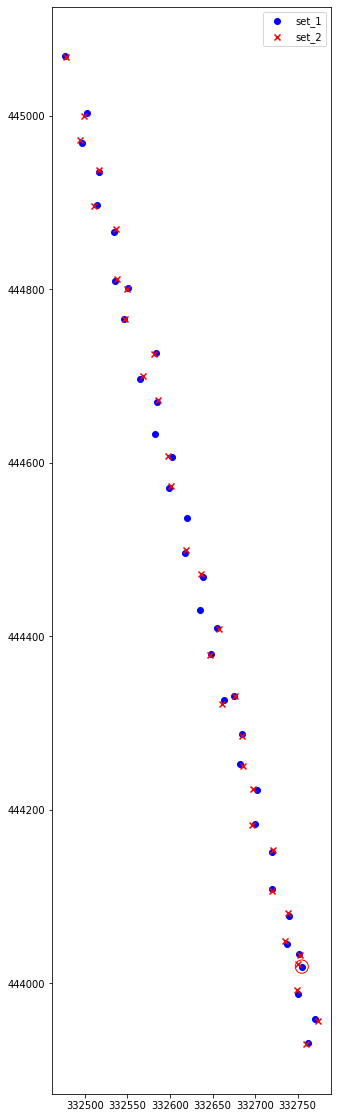

In [12]:
data = asset_update

circle1 = plt.Circle((332755.0, 444019.0), 7.6485, fill=False, color='r')

fig = plt.figure(figsize=(5, 20))
ax1 = fig.add_subplot(111)

ax1.scatter(data['x_1'], data['y_1'], c='b', marker="o", label='set_1')
ax1.scatter(data['x_2'], data['y_2'], c='r', marker="x", label='set_2')
ax1.add_patch(circle1)
plt.legend(loc='upper right')
plt.show()

In [13]:
from scipy import spatial
new_asset_1 = asset_1[['x', 'y', 'ID']]
new_asset_2 = asset_2[['x', 'y', 'UID']]
print(new_asset_1.head(), '\n', new_asset_1.shape)
print(new_asset_2.head(), '\n', new_asset_2.shape)

          x         y  ID
0  332476.0  445069.0  A1
1  332496.0  444969.0  A2
2  332502.0  445003.0  A3
3  332514.0  444897.0  A4
4  332516.0  444935.0  A5 
 (36, 3)
           x          y  UID
0  332477.36  445068.32  Z26
1  332493.84  444971.72   Z2
2  332498.44  445039.62   Z1
3  332499.14  445000.25  Z17
4  332510.64  444896.40  Z23 
 (39, 3)


In [40]:
asset_1_arrays = new_asset_1[['x', 'y']].values
asset_2_arrays = new_asset_2[['x', 'y']].values
asset_1_arrays.shape

(36, 2)

In [41]:
tree = spatial.KDTree(asset_2_arrays)


In [57]:
UID_list = []
for i in asset_1_arrays:
    result = tree.query([(i[0], i[1])])
    UID_list.append(new_asset_2.iloc[result[1][0]]['UID'])




#tree.query([(332664.0, 444326.0)])

Results are very similar except that the KD_tree will always match a point. Computation speed is much faster than using for loop with linalg.norm.

In [59]:
compare = pd.DataFrame({'original_UID':UID, 'KD_tree_UID':UID_list})
compare

,original_UID,KD_tree_UID
0,Z26,Z26
1,Z2,Z2
2,Z17,Z17
3,Z23,Z23
4,Z6,Z6
5,Z13,Z13
6,Z5,Z5
7,Z14,Z14
8,Z11,Z11
9,Z35,Z35
